# TensorFlow Hub 를 이용한 Transfer Learning

- Pre-trained Moblenet 사용  
- gpu 필요하므로 Colab 에서 작업

In [1]:
!pip install tensorflow==2.13.0
!pip install tensorflow_hub==0.14.0

## STEP #1: IMPORT LIBRARIES

In [2]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.applications.mobilenet import decode_predictions

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import sys

## STEP #2: Tensorflow Hub 에서 PRE-TRAINED MOBILENET 의 WEIGHT 를 가져옴  

- Fine Tuning 없이 사용하기 위해 Full Model download

In [3]:
Trained_MobileNet_url = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/2"

In [5]:
Trained_Mobilenet = tf.keras.Sequential([
                    hub.KerasLayer(Trained_MobileNet_url , input_shape=(224,224,3))]
                    )

In [6]:
Trained_Mobilenet.input, Trained_Mobilenet.output

(<KerasTensor: shape=(None, 224, 224, 3) dtype=float32 (created by layer 'keras_layer_input')>,
 <KerasTensor: shape=(None, 1001) dtype=float32 (created by layer 'keras_layer')>)

## STEP #3: 특정 domain 의 Batch Image 에 대한 MobileNet 평가 - No Fine Tuning

### MobileNet 은 Flower 에 특화된 model 이 아니므로 정확도 낮을 것 예상

In [7]:
# Specify path of the flowers dataset
flowers_data_path = tf.keras.utils.get_file(
  'flower_photos','https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
    untar=True)

228813984/228813984 [==============================] - 1s 0us/step


In [8]:
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(
            preprocessing_function=tf.keras.applications.mobilenet.preprocess_input)

flowers_data = image_generator.flow_from_directory(flowers_data_path,
                    target_size=(224, 224), batch_size = 64, shuffle = True)

Found 3670 images belonging to 5 classes.


- flower data 는 5 개의 class 로 구성

In [9]:
input_batch, label_batch = next(flowers_data)

print("Image batch shape: ", input_batch.shape)
print("Label batch shape: ", label_batch.shape)
print("Label class 수: ", flowers_data.num_classes)
print("Class Index : ", flowers_data.class_indices)

Image batch shape:  (64, 224, 224, 3)
Label batch shape:  (64, 5)
Label class 수:  5
Class Index :  {'daisy': 0, 'dandelion': 1, 'roses': 2, 'sunflowers': 3, 'tulips': 4}


In [10]:
class_names = {v:k for k,v in flowers_data.class_indices.items()}
class_names

{0: 'daisy', 1: 'dandelion', 2: 'roses', 3: 'sunflowers', 4: 'tulips'}

- 10 개 image 시각화

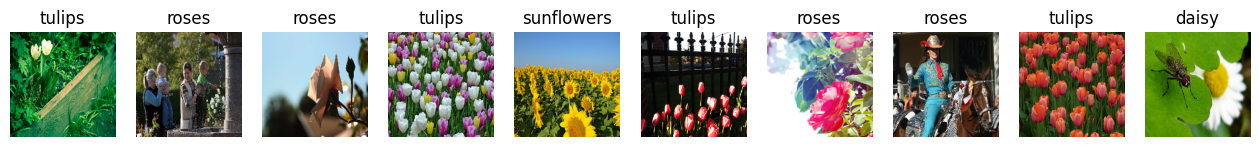

In [11]:
plt.figure(figsize=(16, 8))

for i in range(10):
    plt.subplot(1, 10, i+1)
    img = ((input_batch[i]+1)*127.5).astype(np.uint8)
    idx  = np.argmax(label_batch[i])
    plt.imshow(img)
    plt.title(class_names[idx])
    plt.axis('off')

- 임의의 꽃 image 1 개를 선택하여 prediction 비교

In [12]:
prediction = Trained_Mobilenet.predict(input_batch[2:3])
prediction.shape

1/1 [==============================] - 0s 460ms/step


(1, 1001)

In [13]:
decode_predictions(prediction[:, 1:])

35363/35363 [==============================] - 0s 0us/step


[[('n03759954', 'microphone', 5.389462),
  ('n03617480', 'kimono', 5.3296676),
  ('n02992211', 'cello', 5.2352123),
  ('n04286575', 'spotlight', 5.0941763),
  ('n04141076', 'sax', 5.0469418)]]

# STEP #4: 전이학습 MODEL 을 Flower 분류에 적합한 model 로 Retrain

### Fine Tuning 을 위해 head 가 제거된 model 을 download  

- https://tfhub.dev/s?module-type=image-feature-vector&q=tf2

In [14]:
extractor_url = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/2"

In [15]:
extractor_layer = hub.KerasLayer(extractor_url, input_shape=(224, 224, 3))

In [16]:
feature_batch = extractor_layer(input_batch)
print(feature_batch.shape)

(64, 1280)


- MobileNet 의 pre-trained weight 는 update 않음  

- Top layer 에 Dense layer 추가

In [17]:
extractor_layer.trainable = False

In [18]:
# Build a model with two pieces:
#    (1)  MobileNet Feature Extractor
#    (2)  Dense Network (classifier) added at the end

model = tf.keras.Sequential([
  extractor_layer,
  tf.keras.layers.Dense(flowers_data.num_classes, activation='softmax')
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_1 (KerasLayer)  (None, 1280)              2257984   
                                                                 
 dense (Dense)               (None, 5)                 6405      
                                                                 
Total params: 2264389 (8.64 MB)
Trainable params: 6405 (25.02 KB)
Non-trainable params: 2257984 (8.61 MB)
_________________________________________________________________


In [19]:
model.input, model.output

(<KerasTensor: shape=(None, 224, 224, 3) dtype=float32 (created by layer 'keras_layer_1_input')>,
 <KerasTensor: shape=(None, 5) dtype=float32 (created by layer 'dense')>)

- output shape 이 정확한지 training 전에 사전 check

In [20]:
predictions = model(input_batch)

In [21]:
predictions.shape

TensorShape([64, 5])

In [22]:
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='categorical_crossentropy', metrics=['accuracy'])

In [23]:
history = model.fit(flowers_data, epochs=30)

Epoch 1/30
58/58 [==============================] - 42s 661ms/step - loss: 0.8738 - accuracy: 0.6858
Epoch 2/30
58/58 [==============================] - 38s 644ms/step - loss: 0.4612 - accuracy: 0.8444
Epoch 3/30
58/58 [==============================] - 37s 627ms/step - loss: 0.3793 - accuracy: 0.8703
Epoch 4/30
58/58 [==============================] - 36s 621ms/step - loss: 0.3264 - accuracy: 0.8918
Epoch 5/30
58/58 [==============================] - 36s 614ms/step - loss: 0.2934 - accuracy: 0.9079
Epoch 6/30
58/58 [==============================] - 36s 618ms/step - loss: 0.2668 - accuracy: 0.9188
Epoch 7/30
58/58 [==============================] - 36s 618ms/step - loss: 0.2497 - accuracy: 0.9210
Epoch 8/30
58/58 [==============================] - 36s 629ms/step - loss: 0.2291 - accuracy: 0.9300
Epoch 9/30
58/58 [==============================] - 36s 615ms/step - loss: 0.2109 - accuracy: 0.9379
Epoch 10/30
58/58 [==============================] - 36s 622ms/step - loss: 0.1957 - accura

# STEP #5: Flower 분류 전문으로 Fine Tuning 된 MODEL 평가

In [24]:
y_pred = model.predict(input_batch)
y_pred = np.argmax(y_pred, axis=-1)
y_pred

2/2 [==============================] - 1s 245ms/step


array([4, 2, 2, 4, 3, 4, 2, 2, 4, 0, 3, 4, 3, 3, 2, 1, 0, 4, 3, 1, 1, 3,
       3, 4, 3, 3, 2, 1, 0, 3, 2, 0, 0, 3, 2, 0, 4, 1, 0, 4, 2, 1, 1, 3,
       3, 1, 3, 1, 0, 1, 4, 2, 1, 0, 4, 4, 1, 1, 1, 4, 1, 0, 4, 2])

In [25]:
y_true = np.argmax(label_batch, axis=-1)
y_true

array([4, 2, 2, 4, 3, 4, 2, 2, 4, 0, 3, 4, 3, 3, 2, 1, 0, 4, 3, 1, 1, 3,
       3, 4, 3, 3, 2, 1, 0, 3, 2, 0, 0, 3, 2, 0, 4, 1, 0, 4, 2, 1, 1, 3,
       3, 1, 3, 1, 0, 1, 4, 2, 1, 0, 4, 4, 1, 1, 1, 4, 1, 0, 4, 2])

In [26]:
f"{sum(y_pred == y_true) / len(y_true) * 100:.2f} %"

'100.00 %'

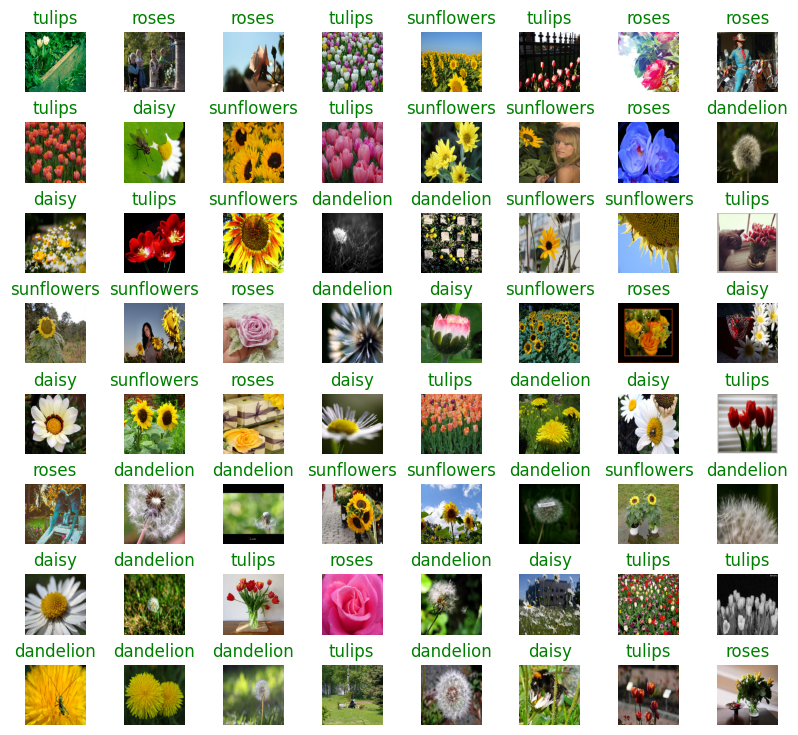

In [27]:
plt.figure(figsize=(10,9))
# 서브플롯 사이의 공간 조정
plt.subplots_adjust(hspace=0.5)

# 64개의 이미지를 8x8 격자로 표시
for i in range(64):
  plt.subplot(8, 8, i+1)        # 8x8 격자에 서브플롯 할당
  img = ((input_batch[i]+1)*127.5).astype(np.uint8)  # 이미지 전처리 (정규화된 데이터를 다시 이미지로 변환)
  plt.imshow(img)  # 이미지 표시
  color = "green" if y_pred[i] == y_true[i] else "red"  # 예측이 정확하면 녹색, 그렇지 않으면 적색으로 설정
  plt.title(class_names[y_pred[i]], color=color)  # 서브플롯 제목에 예측 클래스 이름 표시
  plt.axis('off')  # 축 눈금 제거

# 그래프를 화면에 표시
plt.show()